### Lab 2: Neural Machine Translation in the wild
In the third homework you are supposed to get the best translation you can for the EN-RU translation task.

Basic approach using RNNs as encoder and decoder is implemented for you. 

Your ultimate task is to use the techniques we've covered, e.g.

* Optimization enhancements (e.g. learning rate decay)

* CNN encoder (with or without positional encoding)

* attention/self-attention mechanism

* pretraining the language model

* [Byte Pair Encoding](https://github.com/rsennrich/subword-nmt)

* or just fine-tunning BERT ;)

to improve the translation quality. 

__Please use at least three different approaches/models and compare them (translation quality/complexity/training and evaluation time).__

Write down some summary on your experiments and illustrate it with convergence plots/metrics and your thoughts. Just like you would approach a real problem.

In [1]:
# for colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd drive/MyDrive/NLP_LAB2/

/content/drive/MyDrive/NLP_LAB2


In [3]:
%%capture

# You might need to install the libraries below. Do it in the desired environment
# if you are working locally.

!pip install torchtext
!pip install nltk
!pip install transformers
!pip install youtokentome

In [4]:
# Thanks to YSDA NLP course team for the data
# (who thanks tilda and deephack teams for the data in their turn)

import os
path_to_data = './data.txt'

if not os.path.exists(path_to_data):
    print("Dataset not found locally. Downloading from github. Loading special files as well")
    !wget https://raw.githubusercontent.com/neychev/made_nlp_course/spring2021/datasets/Machine_translation_EN_RU/data.txt -nc
    path_to_data = './data.txt'

In [5]:
import math
import time
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchtext
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu
from transformers import AutoTokenizer, AutoModel
import youtokentome as yttm

from tqdm.notebook import tqdm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
%matplotlib inline
sns.set_style("dark")
from IPython.display import clear_output

In [6]:
# make folder to save checkpoints
os.makedirs(os.path.join(os.getcwd(), "checkpoints/"), exist_ok=True)

In [7]:
SEED = 777

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Load models and utils from own modules

In [ ]:
# %load_ext autoreload
# %autoreload 1
# %aimport utils

In [9]:
from utils import *
from models import *

Try to achieve at least __24__ BLEU on the test set. 
The checkpoints are:

* __22__ - minimal score to submit the homework, 30% of points

* __27__ - good score, 70% of points

* __29__ - excellent score, 100% of points

### Preprocessing

In [ ]:
wp_tokenizer = WordPunctTokenizer()

SRC = Field(
    tokenize=lambda x: wp_tokenizer.tokenize(x.lower()),
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

TRG = Field(
    tokenize=lambda x: wp_tokenizer.tokenize(x.lower()),
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

In [ ]:
BATCH_SIZE = 128

(SRC, TRG), (train_data, valid_data, test_data), (train_iterator, valid_iterator, test_iterator) = prepare_iterators(SRC, TRG, BATCH_SIZE, device, path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500

Unique tokens in source (ru) vocabulary: 9289
Unique tokens in target (en) vocabulary: 6746


Here are few tokens from original (RU) corpus and from target (EN) corpus:

In [ ]:
SRC.vocab.itos[::1000], TRG.vocab.itos[::1000]

(['<unk>',
  'home',
  'шезлонгах',
  'зеленых',
  'chiado',
  '86',
  'lion',
  'финансового',
  'детское',
  'сычуаньской'],
 ['<unk>', 'perfect', 'desks', 'classics', 'nikola', 'scandic', 'm3'])

And here is example from train dataset:

In [ ]:
example = vars(train_data.examples[17])
print(f"SRC: {example['src']}\nTRG: {example['trg']}")

SRC: ['номера', 'оснащены', 'телевизором', ',', 'а', 'в', 'некоторых', 'есть', 'кондиционер', '.', 'в', 'распоряжении', 'гостей', 'общая', 'ванная', 'комната', '.']
TRG: ['rooms', 'include', 'a', 'tv', '.', 'each', 'room', 'has', 'a', 'shared', 'bathroom', 'and', 'some', 'are', 'air', 'conditioned', '.']


Let's check the length distributions:

Length distribution in Train data


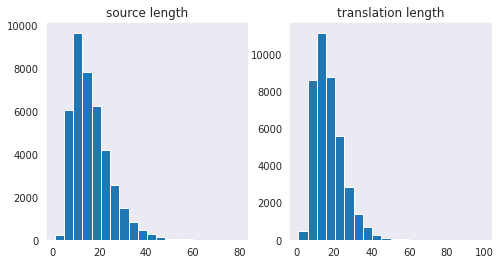

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
show_length_distributions(src_length, trg_length)

Length distribution in Test data


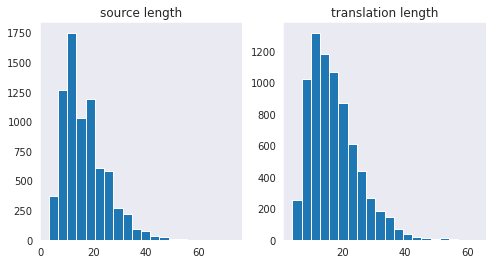

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
show_length_distributions(src_length, trg_length)

Let us observe multiple approaches and architectures for solving this task, starting with RNN-RNN Seq2Seq model.

### RNN -> RNN

In this model hidden and cell state of encoder LSTM is passed to decoder LSTM.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4

# define model
enc = LSTMEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = LSTMDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = LSTMSeq2Seq(enc, dec, device).to(device)

model.apply(initialize_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,922,074 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 11
CLIP = 1.

best_valid_loss = float('inf')

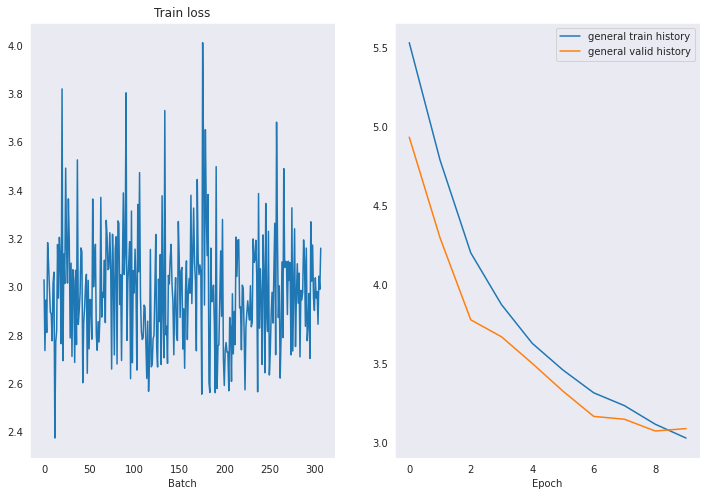

Epoch: 11 | Time: 1m 58s
	Train Loss: 2.979 | Train PPL:  19.661
	 Val. Loss: 2.986 |  Val. PPL:  19.816
Total time: 21m 59s


In [ ]:
start_time = time.time()
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion)
    
    epoch_end_time = time.time()
    
    epoch_mins, epoch_secs = report_time(epoch_start_time, epoch_end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoints/checkpoint_nmt_lstm.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if epoch + 1 == N_EPOCHS:
        total_mins, total_secs = report_time(start_time, epoch_end_time)
        print(f'Total time: {total_mins}m {total_secs}s')

Results and evaluation

In [ ]:
batch = next(iter(test_iterator))
start_ix, end_ix = 10, 16
src = batch.src[:, start_ix:end_ix]
trg = batch.trg[:, start_ix:end_ix]
orig, gen = generate_batch_translation(src, trg, model, TRG=TRG)

Original: room service is also available .
Generated: room service .

Original: extras include ironing facilities .
Generated: extras include a washing machine .

Original: free private parking is available on site .
Generated: free private parking is available on site .

Original: guests can enjoy a meal at the on - site restaurant .
Generated: a restaurant and a bar .

Original: free wi - fi access is available .
Generated: free wifi access is available in all areas .

Original: rooms are equipped with a tv .
Generated: a flat - screen tv .



In [ ]:
# LSTM
bleu = calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 14.156


### RNN -> Attention -> RNN

Now we try to improve RNN-RNN translation with help of attention mechanism: we save encoded outputs of last encoder layer and observe them from decoder, thus we pay more attention :) to encoder output. Encoder's hidden state is passed to decoder as usual.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.4
DEC_DROPOUT = 0.4

# define model
attn = Attention(ENC_HID_DIM, DEC_HID_DIM)
enc = GRUEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = GRUAttnDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)
model = GRUAttnSeq2Seq(enc, dec, device).to(device)

model.apply(initialize_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 22,633,818 trainable parameters


In [ ]:
PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1.

best_valid_loss = float('inf')

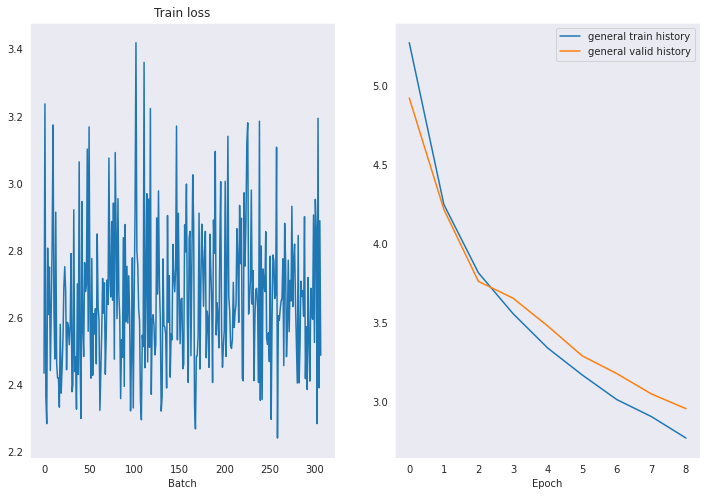

Epoch: 10 | Time: 4m 41s
	Train Loss: 2.658 | Train PPL:  14.264
	 Val. Loss: 2.946 |  Val. PPL:  19.034
Total time: 46m 40s


In [ ]:
start_time = time.time()
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion)
    
    epoch_end_time = time.time()
    
    epoch_mins, epoch_secs = report_time(epoch_start_time, epoch_end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoints/checkpoint_nmt_gru.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if epoch + 1 == N_EPOCHS:
        total_mins, total_secs = report_time(start_time, epoch_end_time)
        print(f'Total time: {total_mins}m {total_secs}s')

Results and evaluation

In [ ]:
batch = next(iter(test_iterator))
start_ix, end_ix = 10, 16
src = batch.src[:, start_ix:end_ix]
trg = batch.trg[:, start_ix:end_ix]
orig, gen = generate_batch_translation(src, trg, model, TRG=TRG)

Original: room service is also available .
Generated: room service is available for guests can be arranged for an extra fee .

Original: extras include ironing facilities .
Generated: ironing facilities like ironing facilities are available upon request .

Original: free private parking is available on site .
Generated: free private parking is available on site and free private parking is available on site .

Original: guests can enjoy a meal at the on - site restaurant .
Generated: guests can enjoy the on - site restaurant , on site restaurant , and restaurant .

Original: free wi - fi access is available .
Generated: free wifi access is available in all areas and free wi - fi access is available .

Original: rooms are equipped with a tv .
Generated: each room comes with a tv and a tv .



In [ ]:
# gru+attention
bleu = calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 21.108


We see that BLEU results became much better, however there are many ways for improvement.

### Transformer -> Transformer

Now we implement architecture that consist only of attention mechanism. Encoder layer is Transformer encoder that uses self-attention, decoder layer uses both self-attention and attention to encoder outputs.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
N_HEADS = 8
N_LAYERS = 3
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_INIT_IDX = TRG.vocab.stoi[TRG.init_token]

# define model
enc = AttentionEncoder(INPUT_DIM, EMB_DIM, N_HEADS, N_LAYERS, ENC_DROPOUT, device, input_max_length=100)
dec = AttentionDecoder(OUTPUT_DIM, EMB_DIM, N_HEADS, N_LAYERS, DEC_DROPOUT, device, output_max_length=100)
model = AttentionSeq2Seq(enc, dec, device, SRC_PAD_IDX, TRG_PAD_IDX, TRG_INIT_IDX).to(device)

model.apply(initialize_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 14,571,354 trainable parameters


In [ ]:
# model.load_state_dict(torch.load("checkpoint_nmt_attn.pth", map_location=device))

In [ ]:
PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 10
CLIP = 1.

best_valid_loss = float('inf')

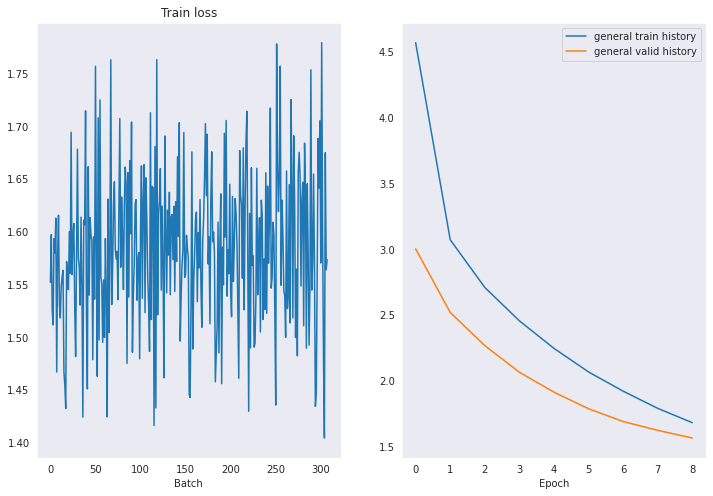

Epoch: 10 | Time: 1m 16s
	Train Loss: 1.583 | Train PPL:   4.871
	 Val. Loss: 1.516 |  Val. PPL:   4.554
Total time: 12m 30s


In [ ]:
start_time = time.time()
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion)
    
    epoch_end_time = time.time()
    
    epoch_mins, epoch_secs = report_time(epoch_start_time, epoch_end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoints/checkpoint_nmt_attn.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if epoch + 1 == N_EPOCHS:
        total_mins, total_secs = report_time(start_time, epoch_end_time)
        print(f'Total time: {total_mins}m {total_secs}s')

Results and evaluation

In [ ]:
batch = next(iter(test_iterator))
start_ix, end_ix = 10, 16
src = batch.src[:, start_ix:end_ix]
trg = batch.trg[:, start_ix:end_ix]
orig, gen = generate_batch_translation(src, trg, model, TRG=TRG)

Original: room service is also available .
Generated: room service is available .

Original: extras include ironing facilities .
Generated: ironing facilities are also available .

Original: free private parking is available on site .
Generated: free private parking is available on site .

Original: guests can enjoy a meal at the on - site restaurant .
Generated: guests can enjoy the on - site restaurant .

Original: free wi - fi access is available .
Generated: free wifi access is available .

Original: rooms are equipped with a tv .
Generated: all rooms are equipped with a tv .



In [ ]:
# attention
bleu = calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 31.284


Excellent, the best score is achieved :)

Now I would like to experiment with other approaches to do even better.

### BERT 

Here I try to use DeepPavlov RUBERT encoder outputs as input to Transformer decoder.

At first we need to load pretrained model, it is quite heavy. To work with such models we also need to use respective tokenizer and construct source and target torchtext fields once again. 

In [10]:
BERT_NAME = "DeepPavlov/rubert-base-cased"

bert_tokenizer = AutoTokenizer.from_pretrained(BERT_NAME)
bert_model = AutoModel.from_pretrained(BERT_NAME)

wp_tokenizer = WordPunctTokenizer()

SRC_BERT = Field(
    tokenize=lambda x: bert_tokenizer.tokenize(x.lower(), add_special_tokens=True),
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

TRG = Field(
    tokenize=lambda x: wp_tokenizer.tokenize(x.lower()),
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

Batch size is now lowered to pass memory limit.

In [11]:
%%time
BATCH_SIZE = 32

(SRC_BERT, TRG), (train_data, valid_data, test_data), (train_iterator, valid_iterator, test_iterator) = prepare_iterators(SRC_BERT, TRG, BATCH_SIZE, device, path_to_data)

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500

Unique tokens in source (ru) vocabulary: 10819
Unique tokens in target (en) vocabulary: 6746
CPU times: user 13.6 s, sys: 1min 18s, total: 1min 32s
Wall time: 1min 32s


Here are few tokens from original (RU) corpus and from target (EN) corpus:

In [12]:
SRC_BERT.vocab.itos[::1000], TRG.vocab.itos[::1000]

(['<unk>',
  'ад',
  'ро',
  '##ella',
  'кла',
  'рыбу',
  'кил',
  'cz',
  'область',
  'населенного',
  'аркад'],
 ['<unk>', 'perfect', 'desks', 'classics', 'nikola', 'scandic', 'm3'])

And here is example from train dataset:

In [13]:
example = vars(train_data.examples[17])
print(f"SRC: {example['src']}\nTRG: {example['trg']}")

SRC: ['[cls]', 'номера', 'оснащены', 'телевизор', '##ом', ',', 'а', 'в', 'некоторых', 'есть', 'кондицион', '##ер', '.', 'в', 'распоряжении', 'гост', '##еи', 'общая', 'ванн', '##ая', 'комната', '.', '[sep]']
TRG: ['rooms', 'include', 'a', 'tv', '.', 'each', 'room', 'has', 'a', 'shared', 'bathroom', 'and', 'some', 'are', 'air', 'conditioned', '.']


Let's check the length distributions:

Length distribution in Train data


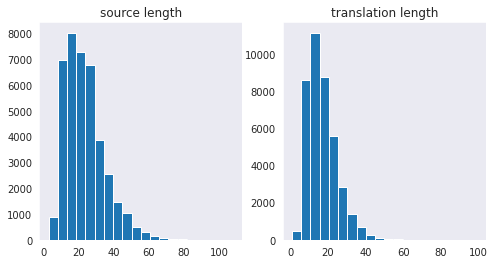

In [14]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
show_length_distributions(src_length, trg_length)

Length distribution in Test data


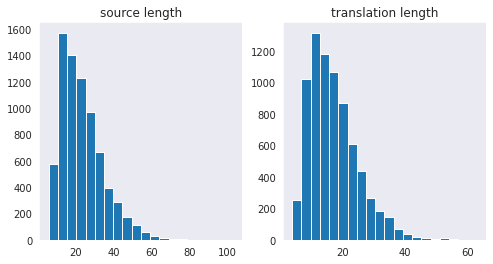

In [15]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
show_length_distributions(src_length, trg_length)

In [16]:
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
N_HEADS = 8
N_LAYERS = 3
DEC_DROPOUT = 0.2
SRC_PAD_IDX = SRC_BERT.vocab.stoi[SRC_BERT.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
TRG_INIT_IDX = TRG.vocab.stoi[TRG.init_token]

# define model
enc = BERTEncoder(bert_model, EMB_DIM)
dec = AttentionDecoder(OUTPUT_DIM, EMB_DIM, N_HEADS, N_LAYERS, DEC_DROPOUT, device)
model = AttentionSeq2Seq(enc, dec, device, SRC_PAD_IDX, TRG_PAD_IDX, TRG_INIT_IDX).to(device)

# initialize weights of the model, but bert_model from BERTEncoder should not be reinitialized!!!
model.decoder.apply(initialize_weights);
model.encoder.fc.apply(initialize_weights);

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 186,280,026 trainable parameters


In [17]:
PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 11
CLIP = 1.

best_valid_loss = float('inf')

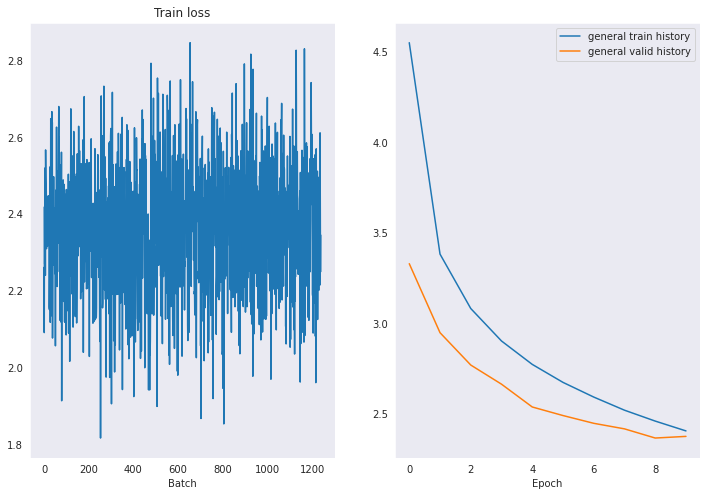

Epoch: 11 | Time: 3m 15s
	Train Loss: 2.357 | Train PPL:  10.559
	 Val. Loss: 2.364 |  Val. PPL:  10.634
Total time: 36m 54s


In [18]:
start_time = time.time()
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion)
    
    epoch_end_time = time.time()
    
    epoch_mins, epoch_secs = report_time(epoch_start_time, epoch_end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoints/checkpoint_nmt_bert.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if epoch + 1 == N_EPOCHS:
        total_mins, total_secs = report_time(start_time, epoch_end_time)
        print(f'Total time: {total_mins}m {total_secs}s')

Results and evaluation

In [20]:
batch = next(iter(test_iterator))
start_ix, end_ix = 10, 16
src = batch.src[:, start_ix:end_ix]
trg = batch.trg[:, start_ix:end_ix]
orig, gen = generate_batch_translation(src, trg, model, TRG=TRG)

Original: there is a restaurant and guests can have fun at the bowling alley .
Generated: free wifi is available throughout the property .

Original: private parking is free .
Generated: free wifi is available throughout the property and free private parking is available on site .

Original: bed linen is provided .
Generated: the en suite bathroom includes a shower , hairdryer and free toiletries .

Original: free private parking is available on site .
Generated: the apartment features a living room with a sofa and a flat - screen tv .

Original: the property offers free parking .
Generated: free wifi is available throughout the property .

Original: there is a lift to access the apartment .
Generated: the property is 1 . 5 km from the and 1 . 5 km from the property .



In [21]:
# BERT
bleu = calculate_bleu(model, test_iterator, TRG)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 7.888


Unfortunately, the results are very poor. I guess the reasons of such low score are as follows:

- Small vocabulary size of the task. I guess that BERT usage is useful on very large datasets, but for small tasks own architectures from scratch would deliver better results.

- Raw BERT encoder outputs are taken with no fine-tuning. I tried to do fine-tuning via unfreezing, but the process was rather slow and memory limits were exceeded numerous times. I suppose that properly written procedure with unfreezing of layers in correct order, properly taken learing rate and scheduler would demonstrate power of BERT.

### Byte Pair Encoding

Finally I decided to make tokenization via Byte Pair Encoding. I trained BPE model from YouTokenToMe library and used it as a tokenizer.

Complexity of the Seq2Seq model may be regulated by choice of different vocab size of BPE model. The smaller vocab size is chosen - the longer encoded sentences we get.

In [22]:
path_split_data = "split_data/"
path_split_data = os.path.join(os.getcwd(), path_split_data)
prepare_split_datasets(path_to_data, path_split_data)

In [23]:
# train and load saved BPE model

bpe_model_path = "bpe.model"
bpe_model_path = os.path.join(os.getcwd(), bpe_model_path)

yttm.BPE.train(data=os.path.join(path_split_data, "train_data.txt"), model=bpe_model_path, vocab_size=7000)
bpe_model = yttm.BPE(model=bpe_model_path)

In [24]:
wp_tokenizer = WordPunctTokenizer()

def bpe_tokenize(x, bpe_model=bpe_model, wp_tokenizer=wp_tokenizer):
    x = " ".join(wp_tokenizer.tokenize(x.lower()))
    return bpe_model.encode(x, output_type=yttm.OutputType.SUBWORD)

SRC_BPE = Field(
    tokenize=bpe_tokenize,
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

TRG_BPE = Field(
    tokenize=bpe_tokenize,
    init_token = '<sos>', 
    eos_token = '<eos>', 
    lower = True,
)

In [25]:
BATCH_SIZE = 128

train_path = os.path.join(path_split_data, "train_data.txt")
val_path = os.path.join(path_split_data, "val_data.txt")
test_path = os.path.join(path_split_data, "test_data.txt")

(SRC_BPE, TRG_BPE), datasets, iterators = prepare_iterators(
    SRC_BPE, TRG_BPE, BATCH_SIZE, device, path_to_data=None, 
    train_path=train_path, val_path=val_path, test_path=test_path,
)
train_data, valid_data, test_data = datasets
train_iterator, valid_iterator, test_iterator = iterators

Number of training examples: 40000
Number of validation examples: 2500
Number of testing examples: 7500

Unique tokens in source (ru) vocabulary: 3889
Unique tokens in target (en) vocabulary: 2061


We see that with BPE vocab size of 7000 tokens we have smaller ru/en vocabulary of NMT model.

Here are few tokens from original (RU) corpus and from target (EN) corpus:

In [ ]:
SRC_BPE.vocab.itos[::1000], TRG_BPE.vocab.itos[::1000]

(['<unk>', '▁места', '▁берега', 'és'], ['<unk>', 'ural', 'reet'])

And here is example from train dataset:

In [ ]:
example = vars(train_data.examples[17])
print(f"SRC_BPE: {example['src']}\nTRG_BPE: {example['trg']}")

SRC_BPE: ['▁предоставляются', '▁необходим', 'ые', '▁принадлежности', '▁', ',', '▁в', '▁част', 'ности', '▁', ',', '▁би', 'но', 'к', 'ли', '▁и', '▁теле', 'ско', 'п', 'ы', '▁.']
TRG_BPE: ['▁a', '▁g', 'u', 'ide', '▁and', '▁equipment', '▁such', '▁as', '▁b', 'in', 'oc', 'ular', 's', '▁and', '▁', 'tel', 'es', 'c', 'op', 'es', '▁are', '▁provided', '▁.']


In [ ]:
example = vars(train_data.examples[17])
print(f"SRC_BPE: {example['src']}\nTRG_BPE: {example['trg']}")

SRC_BPE: ['▁предоставляются', '▁необходим', 'ые', '▁принадлежности', '▁', ',', '▁в', '▁част', 'ности', '▁', ',', '▁би', 'но', 'к', 'ли', '▁и', '▁теле', 'ско', 'п', 'ы', '▁.']
TRG_BPE: ['▁a', '▁g', 'u', 'ide', '▁and', '▁equipment', '▁such', '▁as', '▁b', 'in', 'oc', 'ular', 's', '▁and', '▁', 'tel', 'es', 'c', 'op', 'es', '▁are', '▁provided', '▁.']


Let's check the length distributions:

Length distribution in Train data


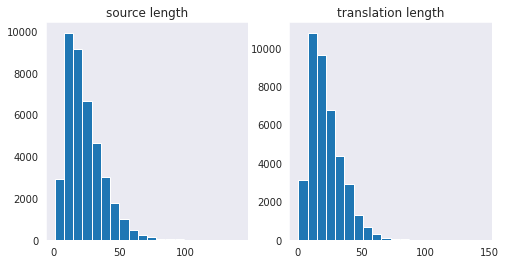

In [ ]:
src_length = map(len, [vars(x)['src'] for x in train_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in train_data.examples])

print('Length distribution in Train data')
show_length_distributions(src_length, trg_length)

Length distribution in Test data


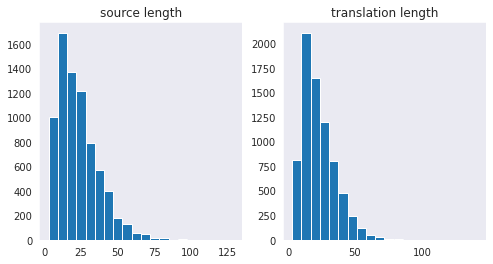

In [ ]:
src_length = map(len, [vars(x)['src'] for x in test_data.examples])
trg_length = map(len, [vars(x)['trg'] for x in test_data.examples])

print('Length distribution in Test data')
show_length_distributions(src_length, trg_length)

We use Transformer-Transformer seq2seq model. Notice that text encoded with BPE has larger length, so let's define larger max length for models.

In [26]:
INPUT_DIM = len(SRC_BPE.vocab)
OUTPUT_DIM = len(TRG_BPE.vocab)
EMB_DIM = 256
N_HEADS = 8
N_LAYERS = 3
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
SRC_PAD_IDX = SRC_BPE.vocab.stoi[SRC_BPE.pad_token]
TRG_PAD_IDX = TRG_BPE.vocab.stoi[TRG_BPE.pad_token]
TRG_INIT_IDX = TRG_BPE.vocab.stoi[TRG_BPE.init_token]

# define model
enc = AttentionEncoder(INPUT_DIM, EMB_DIM, N_HEADS, N_LAYERS, ENC_DROPOUT, device, input_max_length=150)
dec = AttentionDecoder(OUTPUT_DIM, EMB_DIM, N_HEADS, N_LAYERS, DEC_DROPOUT, device, output_max_length=150)
model = AttentionSeq2Seq(enc, dec, device, SRC_PAD_IDX, TRG_PAD_IDX, TRG_INIT_IDX).to(device)

model.apply(initialize_weights);
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 10,811,149 trainable parameters


In [27]:
# model.load_state_dict(torch.load("checkpoint_nmt_bpe.pth", map_location=device))

<All keys matched successfully>

In [ ]:
PAD_IDX = TRG_BPE.vocab.stoi[TRG_BPE.pad_token]
optimizer = optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

train_history = []
valid_history = []

N_EPOCHS = 15
CLIP = 2.

best_valid_loss = float('inf')

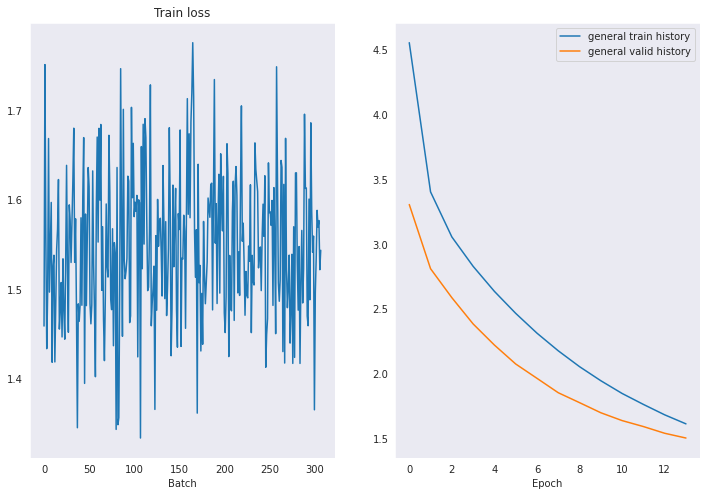

Epoch: 15 | Time: 3m 4s
	Train Loss: 1.548 | Train PPL:   4.703
	 Val. Loss: 1.464 |  Val. PPL:   4.323
Total time: 46m 12s


In [ ]:
# 7k 15ep
start_time = time.time()
for epoch in range(N_EPOCHS):
    
    epoch_start_time = time.time()
    
    train_loss = train_epoch(model, train_iterator, optimizer, criterion, CLIP, train_history, valid_history)
    valid_loss = evaluate_epoch(model, valid_iterator, criterion)

    epoch_end_time = time.time()
    
    epoch_mins, epoch_secs = report_time(epoch_start_time, epoch_end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), './checkpoints/checkpoint_nmt_bpe.pth')
    
    train_history.append(train_loss)
    valid_history.append(valid_loss)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    if epoch + 1 == N_EPOCHS:
        total_mins, total_secs = report_time(start_time, epoch_end_time)
        print(f'Total time: {total_mins}m {total_secs}s')

Results and evaluation

In [29]:
batch = next(iter(test_iterator))
start_ix, end_ix = 10, 16
src = batch.src[:, start_ix:end_ix]
trg = batch.trg[:, start_ix:end_ix]
orig, gen = generate_batch_translation(src, trg, model, TRG=TRG_BPE, bpe_model=bpe_model)

Original: there is free parking on site .
Generated: the property offers free parking .

Original: the apartment will provide you with a balcony .
Generated: the apartment features a balcony .

Original: the property serves daily breakfast .
Generated: daily breakfast is served daily .

Original: guests can benefit from shared bathrooms .
Generated: shared bathroom facilities are shared .

Original: the accommodation is equipped with a tv .
Generated: a tv is featured .

Original: each one has a private bathroom with a hairdryer .
Generated: the private bathroom comes with a hairdryer .



In [28]:
# BPE 7k
bleu = calculate_bleu(model, test_iterator, TRG_BPE, bpe_model=bpe_model)
print(f'BLEU score = {bleu * 100:.3f}')


BLEU score = 30.606


Very good result! 

We see that final BLEU score with BPE usage is close to score of the model that used simple tokenizing. However, we may hope that training procedure was stopped early and we may get better results. (Still, same is fair for Transformer NMT with simple tokenizing)

**Conclusion**:

- Attention models, especially Transformers, easily beat recurrent models, thus usage of Transformers is preferable
- BERT models are powerful, but one needs to handle them very attentively (choice of hyperparameters, proper tuning, etc.)
- Proper tokenization also may help to achieve better results
